# Civil Engineering Machine Learning Project


***
## 1. Data Extraction

In [3]:
"""
Created on Tue Jul 18 03:12:39 2017

@author: Aamir
"""
%matplotlib inline

### Import Libraries

In [151]:

import os
import scipy.io
import numpy as np
import pandas as pd
from math import log10, floor
from datetime import datetime

import keras
from keras.layers import Dense, Dropout, Activation
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
import xgboost as xgb

from IPython.display import SVG
import matplotlib.pyplot as plt

In [5]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

### Load Excel files

In [94]:
temp1 = pd.read_excel("Type 1.xlsx", sheetname="B1")
temp2 = pd.read_excel("Type 1.xlsx", sheetname="B2")
temp3 = pd.read_excel("Type 1.xlsx", sheetname="B3")

In [95]:
temp1.shape, temp2.shape, temp3.shape

((258735, 37), (138661, 42), (162644, 20))

### Clean Columns/Rows

In [96]:
train_set = temp1.iloc[:,0:20]
test_set = temp2.iloc[:,0:21]

In [97]:
train_set = train_set[train_set.ID!='ID']
train_set.dropna(inplace=True)
test_set = test_set[test_set.ID!='ID']
test_set.dropna(inplace=True)

In [104]:
train_set.shape, test_set.shape

((127718, 20), (68534, 20))

In [101]:
test_set['SIG-STRNGTH'] = (test_set["SIG"].astype(str).map(str) + test_set["STRNGTH"].astype(str)).astype(float)
test_set.drop('SIG',axis=1,inplace=True)
test_set.drop('STRNGTH',axis=1,inplace=True)

In [108]:
test_set = test_set[train_set.columns]

### Merge two tables

In [111]:
combined_set = pd.concat([train_set,test_set])

In [113]:
combined_set.reset_index(drop=True,inplace=True)

### Datatype integrity check

In [119]:
combined_set['ID'] = combined_set['ID'].astype(int)
combined_set['DDD'] = combined_set['DDD'].astype(int)
combined_set['PARA1'] = combined_set['PARA1'].astype(float)
combined_set['CH'] = combined_set['CH'].astype(int)
combined_set['RISE'] = combined_set['RISE'].astype(int)
combined_set['COUN'] = combined_set['COUN'].astype(int)
combined_set['ENER'] = combined_set['ENER'].astype(int)
combined_set['DURATION'] = combined_set['DURATION'].astype(int)
combined_set['AMP'] = combined_set['AMP'].astype(int)
combined_set['A-FRQ'] = combined_set['A-FRQ'].astype(int)
combined_set['RMS'] = combined_set['RMS'].astype(float)
combined_set['ASL'] = combined_set['ASL'].astype(int)
combined_set['PCNTS'] = combined_set['PCNTS'].astype(int)
combined_set['THR'] = combined_set['THR'].astype(int)
combined_set['R-FRQ'] = combined_set['R-FRQ'].astype(int)
combined_set['I-FRQ'] = combined_set['I-FRQ'].astype(int)
combined_set['SIG-STRNGTH'] = combined_set['SIG-STRNGTH'].astype(float)
combined_set['ABS-ENERGY'] = combined_set['ABS-ENERGY'].astype(float)
combined_set['DAMAGE'] = combined_set['DAMAGE'].astype(int)

combined_set.dtypes

ID                    int32
DDD                   int32
HH:MM:SS.mmmuuun     object
PARA1               float64
CH                    int32
RISE                  int32
COUN                  int32
ENER                  int32
DURATION              int32
AMP                   int32
A-FRQ                 int32
RMS                 float64
ASL                   int32
PCNTS                 int32
THR                   int32
R-FRQ                 int32
I-FRQ                 int32
SIG-STRNGTH         float64
ABS-ENERGY          float64
DAMAGE                int32
dtype: object

In [120]:
combined_set.to_excel("combinedData.xlsx")

### Feature engineering

In [121]:
combined_set['HR'] = combined_set['HH:MM:SS.mmmuuun'].apply(lambda x: x.hour)
combined_set['MIN'] = combined_set['HH:MM:SS.mmmuuun'].apply(lambda x: x.minute)
combined_set['SEC'] = combined_set['HH:MM:SS.mmmuuun'].apply(lambda x: x.second)
combined_set['USEC'] = combined_set['HH:MM:SS.mmmuuun'].apply(lambda x: x.microsecond)

In [122]:
combined_set.drop('HH:MM:SS.mmmuuun',axis=1,inplace=True)
combined_set.head()

,ID,DDD,PARA1,CH,RISE,COUN,ENER,DURATION,AMP,A-FRQ,...,THR,R-FRQ,I-FRQ,SIG-STRNGTH,ABS-ENERGY,DAMAGE,HR,MIN,SEC,USEC
0,1,0,0.0143,2,21,4,2,134,51,30,...,45,17,95,13088.00,202.701,1,0,1,13,212000
1,1,0,0.0131,4,9,5,2,114,52,44,...,45,38,111,14372.00,260.846,1,0,1,13,505000
2,1,0,0.0131,2,1,1,0,2,47,500,...,45,0,1000,283.65,6.438,1,0,1,14,793000
3,1,0,0.0119,2,1,2,0,55,45,36,...,45,18,1000,4188.00,52.109,1,0,1,14,918000
4,1,0,0.0092,2,27,12,8,442,57,27,...,45,24,74,51280.00,1296.000,1,0,1,15,187000


In [127]:
X_combined = combined_set.copy()
y_combined = X_combined.pop('DAMAGE')
X_combined.shape

(196252, 22)

In [128]:
y_combined.shape

(196252,)

### Split Training/Validation/Test Sets

In [133]:
X_train, X_temp, y_train, y_temp = train_test_split(X_combined, y_combined, test_size=0.1)

In [138]:
X_train.shape, X_temp.shape, y_train.shape, y_temp.shape

((176626, 22), (19626, 22), (176626,), (19626,))

In [139]:
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=10000)

In [140]:
X_valid.shape, X_test.shape, y_valid.shape, y_test.shape

((9626, 22), (10000, 22), (9626,), (10000,))

At the end, we have three sets
- Training set (176626,22) and (176626,)
- Validation set (9626,22) and (9626,)
- Test set (10000,22) and (10000,)

***
## 2. Train the Model

### MODEL 1

In [192]:
my_tree_four = RandomForestClassifier(max_depth=10, min_samples_split=2, n_estimators=50, random_state=1)
my_tree_four = my_tree_four.fit(X_train.values, y_train)

In [193]:
print(my_tree_four.feature_importances_)
print(my_tree_four.score(X_valid.values, y_valid))

[  0.00000000e+00   0.00000000e+00   8.33193793e-04   1.37797117e-02
   1.62823785e-03   2.34467318e-03   1.05154307e-03   2.86075899e-03
   7.12618494e-04   1.54055696e-03   1.15241473e-02   1.45991791e-02
   2.19091770e-03   0.00000000e+00   1.55495064e-03   1.23906209e-03
   2.94232441e-03   1.68634729e-03   0.00000000e+00   9.00653540e-01
   3.74830334e-02   1.37520376e-03]
0.939746519842


In [194]:
my_prediction_four = my_tree_four.predict(X_test)
np.mean(my_prediction_four == y_test)

0.93869999999999998

### MODEL 2

In [175]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(X_train,y_train)

In [176]:
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

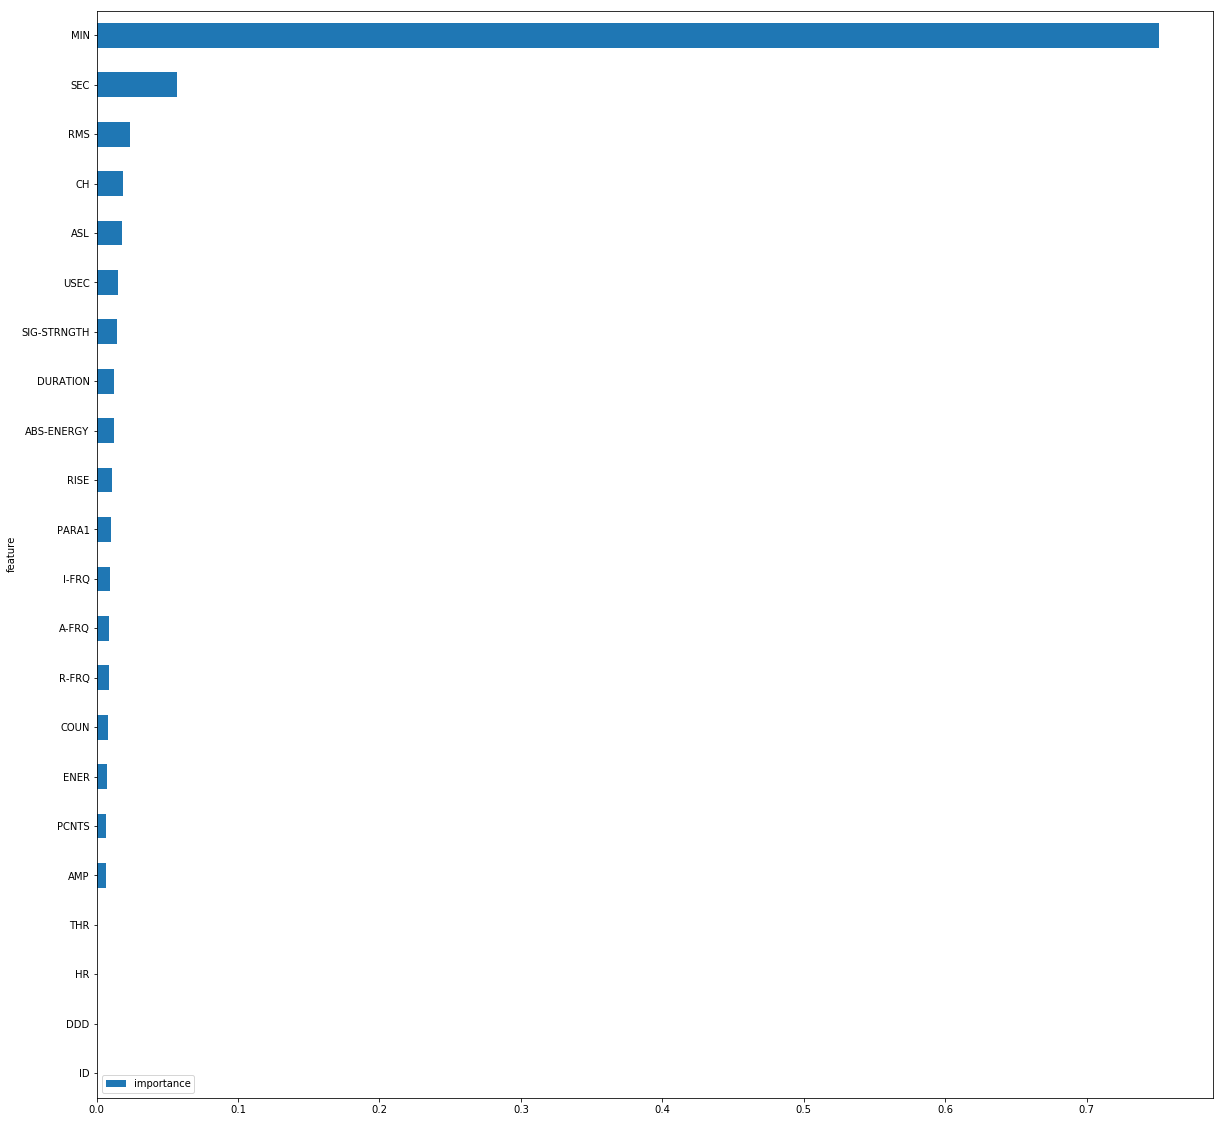

In [177]:
features.plot(kind='barh', figsize=(20, 20))

In [178]:
h_test = clf.predict(X_test)

In [195]:
np.mean(h_test == y_test)

0.97570000000000001

In [200]:
res = pd.DataFrame(h_test,y_test) 

In [202]:
res.to_excel("result.xlsx")

### MODEL 3

In [168]:
parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50,
                'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
model3 = RandomForestClassifier(**parameters)
model3.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [169]:
xval = cross_val_score(model3, X_valid, y_valid, cv = 5, scoring='accuracy')
np.mean(xval)

0.87180586798986792

In [170]:
h_test = model3.predict(X_test)

In [171]:
np.mean(h_test == y_test)

0.86240000000000006

In [172]:
pd.DataFrame(h_test, y_test)

,0
DAMAGE,
4,4
4,4
2,3
3,3
3,3
1,3
4,4
4,4
4,4


***
## 5. Predict the Test set

### Select test model features 

### Make predictions 

***
## 6. Save Results
### Create the Solution 

In [ ]:
my_solution.index.name

### Save to CSV file 

In [ ]:
my_solution.to_csv("my_solution_six.csv")

***
***
# Rough Work 

In [ ]:
%matplotlib inline